In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score
from math import sqrt
import numpy as np

In [4]:
# getting file directory
import os
for dirname, _, filenames in os.walk('C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\allbut.pl
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\mku.sh
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\README
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.data
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.genre
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.info
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.item
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.occupation
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u.user
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u1.base
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u1.test
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u2.base
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u2.test
C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k\u3.base
C:/Users/Acer/OneDrive/Desktop/Sp

# Description of DataSet:

Here are brief descriptions of the data.

u.data -- The full u data set, 100000 ratings by 943 users on 1682 items.
Each user has rated at least 20 movies. Users and items are
numbered consecutively from 1. The data is randomly
ordered. This is a tab separated list of
user id | item id | rating | timestamp.
The time stamps are unix seconds since 1/1/1970 UTC

u.info -- The number of users, items, and ratings in the u data set.

u.item -- Information about the items (movies); this is a tab separated
list of
movie id | movie title | release date | video release date |
IMDb URL | unknown | Action | Adventure | Animation |
Children's | Comedy | Crime | Documentary | Drama | Fantasy |
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
Thriller | War | Western |
The last 19 fields are the genres, a 1 indicates the movie
is of that genre, a 0 indicates it is not; movies can be in
several genres at once.
The movie ids are the ones used in the u.data data set.

u.genre -- A list of the genres.

u.user -- Demographic information about the users; this is a tab
separated list of
user id | age | gender | occupation | zip code
The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test are 80%/20% splits of the u data into training and test data.
u2.base Each of u1, …, u5 have disjoint test sets; this if for
u2.test 5 fold cross validation (where you repeat your experiment
u3.base with each training and test set and average the results).
u3.test These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test split the u data into a training set and a test set with
ub.base exactly 10 ratings per user in the test set. The sets
ub.test ua.test and ub.test are disjoint. These data sets can
be generated from u.data by mku.sh.

# Loading all the data

In [5]:
import pandas as pd
import os

# Set your dataset path
dataset_path = "C:/Users/Acer/OneDrive/Desktop/Springboard/Capstone3/ml-100k"

# File-specific configurations (filename: [separator, column_names])
file_configs = {
    "u.data": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u.item": ["|", [
        "movie_id", "title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure",
        "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
        "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
    ]],
    "u.user": ["|", ["user_id", "age", "gender", "occupation", "zip_code"]],
    "u.genre": ["|", ["genre", "genre_id"]],
    "u.occupation": ["\n", ["occupation"]],
    "u.info": ["\n", ["info"]],
    "ua.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "ua.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "ub.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "ub.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u1.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u1.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u2.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u2.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u3.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u3.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u4.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u4.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u5.base": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
    "u5.test": ["\t", ["user_id", "item_id", "rating", "timestamp"]],
}

# Dictionary to hold all DataFrames
dataframes = {}

# Read files based on config
for file_name, (sep, columns) in file_configs.items():
    file_path = os.path.join(dataset_path, file_name)
    
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        continue
    
    try:
        if sep == "\n":
            # Read single-column files (like u.occupation or u.info)
            df = pd.read_csv(file_path, names=columns, sep=sep, header=None, engine='python')
        else:
            df = pd.read_csv(file_path, names=columns, sep=sep, encoding='latin-1', header=None)
        dataframes[file_name] = df
        print(f"✅ Loaded {file_name} — Shape: {df.shape}")
    except Exception as e:
        print(f"⚠️ Failed to load {file_name}: {e}")

# Example: Accessing one of the DataFrames
dataframes['u.data'].head(10)


✅ Loaded u.data — Shape: (100000, 4)
✅ Loaded u.item — Shape: (1682, 24)
✅ Loaded u.user — Shape: (943, 5)
✅ Loaded u.genre — Shape: (19, 2)
⚠️ Failed to load u.occupation: Specified \n as separator or delimiter. This forces the python engine which does not accept a line terminator. Hence it is not allowed to use the line terminator as separator.
⚠️ Failed to load u.info: Specified \n as separator or delimiter. This forces the python engine which does not accept a line terminator. Hence it is not allowed to use the line terminator as separator.
✅ Loaded ua.base — Shape: (90570, 4)
✅ Loaded ua.test — Shape: (9430, 4)
✅ Loaded ub.base — Shape: (90570, 4)
✅ Loaded ub.test — Shape: (9430, 4)
✅ Loaded u1.base — Shape: (80000, 4)
✅ Loaded u1.test — Shape: (20000, 4)
✅ Loaded u2.base — Shape: (80000, 4)
✅ Loaded u2.test — Shape: (20000, 4)
✅ Loaded u3.base — Shape: (80000, 4)
✅ Loaded u3.test — Shape: (20000, 4)
✅ Loaded u4.base — Shape: (80000, 4)
✅ Loaded u4.test — Shape: (20000, 4)
✅ Loade

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [6]:
dataframes['u.item'].head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
dataframes['u.user'].head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [8]:
dataframes['u.genre'].head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [9]:
dataframes['ua.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [10]:
dataframes['ub.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [11]:
dataframes['ub.test'].head()

,user_id,item_id,rating,timestamp
0,1,17,3,875073198
1,1,47,4,875072125
2,1,64,5,875072404
3,1,90,4,878542300
4,1,92,3,876892425


In [12]:
dataframes['u1.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [13]:
dataframes['u1.test'].head()

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [14]:
dataframes['u2.base'].head()

,user_id,item_id,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [15]:
dataframes['u2.test'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,8,1,875072484
3,1,9,5,878543541
4,1,21,1,878542772


In [16]:
dataframes['u3.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [17]:
dataframes['u3.test'].head()

,user_id,item_id,rating,timestamp
0,1,5,3,889751712
1,1,11,2,875072262
2,1,16,5,878543541
3,1,25,4,875071805
4,1,35,1,878542420


In [18]:
dataframes['u4.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,5,3,889751712
4,1,6,5,887431973


In [19]:
dataframes['u4.test'].head()

,user_id,item_id,rating,timestamp
0,1,4,3,876893119
1,1,7,4,875071561
2,1,42,5,876892425
3,1,43,4,878542869
4,1,55,5,875072688


In [20]:
dataframes['u5.base'].head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,4,3,876893119
3,1,5,3,889751712
4,1,6,5,887431973


In [21]:
dataframes['u5.test'].head()

,user_id,item_id,rating,timestamp
0,1,3,4,878542960
1,1,13,5,875071805
2,1,15,5,875071608
3,1,18,4,887432020
4,1,19,5,875071515


In [22]:
dataset = dataframes['u.data']

In [23]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
item =dataframes['u.item']

In [25]:
item.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
user = dataframes['u.user']

In [27]:
user.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [28]:
genre=dataframes['u.genre']

In [29]:
genre.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


From above datasets our key datasets are:
- u.data – Ratings
- u.item – Movies
- u.user – Users
- u.genre – Genres (optional merge)

# Data Wrangling

In [30]:
# Check for null values in all datasets
print("Null values in dataset:\n", dataset.isnull().sum(), "\n")
print("Null values in item:\n", item.isnull().sum(), "\n")
print("Null values in user:\n", user.isnull().sum(), "\n")
print("Null values in genre:\n", genre.isnull().sum(), "\n")


Null values in dataset:
 user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64 

Null values in item:
 movie_id                 0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64 

Null values in user:
 user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64 

Null values in genre:
 genre       0
genre_id    0
dtype: int64 



There are missing values in item dataset in column - 'video_release_date', we can fill this with 'release_date' column value

In [31]:
# Fill missing video_release_date with release_date if available
item.loc[item['video_release_date'].isnull(), 'video_release_date'] = item['release_date']

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\2811660530.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['01-Jan-1995' '01-Jan-1995' '01-Jan-1995' ... '01-Jan-1998' '01-Jan-1994'
 '08-Mar-1996']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  item.loc[item['video_release_date'].isnull(), 'video_release_date'] = item['release_date']


In [32]:
print("Null values in item:\n", item.isnull().sum(), "\n")

Null values in item:
 movie_id              0
title                 0
release_date          1
video_release_date    1
IMDb_URL              3
unknown               0
Action                0
Adventure             0
Animation             0
Children's            0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64 



In [33]:
item=item.dropna()

In [34]:
print("Null values in item:\n", item.isnull().sum(), "\n")

Null values in item:
 movie_id              0
title                 0
release_date          0
video_release_date    0
IMDb_URL              0
unknown               0
Action                0
Adventure             0
Animation             0
Children's            0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
dtype: int64 



In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [36]:
dataset.loc[:, 'timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')


C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\3176271409.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1997-12-04 15:55:49', '1998-04-04 19:22:22', '1997-11-07 07:18:36',
 '1997-11-27 05:02:03', '1998-02-02 05:33:16', '1998-01-07 14:20:06',
 '1997-12-03 17:51:28', '1998-04-03 18:34:27', '1998-02-01 09:20:17',
 '1997-12-31 21:16:53',
 ...
 '1997-12-17 20:01:37', '1998-04-16 00:10:37', '1997-10-18 01:14:45',
 '1997-12-06 00:12:30', '1997-11-20 20:16:16', '1997-11-22 05:10:44',
 '1997-11-17 19:39:03', '1997-09-20 22:49:55', '1997-12-17 22:52:36',
 '1997-11-19 17:13:03']
Length: 100000, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataset.loc[:, 'timestamp'] = pd.to_datetime(dataset['timestamp'], unit='s')


In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   item_id    100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB


In [38]:
dataset['rating'].value_counts()

rating
4    34174
3    27145
5    21201
2    11370
1     6110
Name: count, dtype: int64

In [39]:
item.columns = [
    "movie_id", "movie_title", "release_date", "video_release_date",
    "IMDb_URL", "unknown", "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
    "Thriller", "War", "Western"
]

In [40]:
# Convert release_date to datetime, handle missing/null values
item.loc[:, 'release_date'] = pd.to_datetime(item['release_date'], errors='coerce')

In [41]:
item.loc[:, 'video_release_date'] = pd.to_datetime(item['video_release_date'], errors='coerce')

In [42]:
item.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1679 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movie_id            1679 non-null   int64 
 1   movie_title         1679 non-null   object
 2   release_date        1679 non-null   object
 3   video_release_date  1679 non-null   object
 4   IMDb_URL            1679 non-null   object
 5   unknown             1679 non-null   int64 
 6   Action              1679 non-null   int64 
 7   Adventure           1679 non-null   int64 
 8   Animation           1679 non-null   int64 
 9   Children's          1679 non-null   int64 
 10  Comedy              1679 non-null   int64 
 11  Crime               1679 non-null   int64 
 12  Documentary         1679 non-null   int64 
 13  Drama               1679 non-null   int64 
 14  Fantasy             1679 non-null   int64 
 15  Film-Noir           1679 non-null   int64 
 16  Horror              1679 non-

In [43]:
user.columns = ["user_id", "age", "gender", "occupation", "zip_code"]

In [44]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [45]:
user[(user['age'].isna())]

,user_id,age,gender,occupation,zip_code


In [46]:
user[(user['age'] > 120)|(user['age']<0)]

,user_id,age,gender,occupation,zip_code


There is no invalied age present

In [47]:
genre.columns = ["genre", "genre_id"]

In [48]:
# Show rows where NaNs exist in any dataframe
print("NaNs in item:")
print(item[item.isnull().any(axis=1)])

NaNs in item:
Empty DataFrame
Columns: [movie_id, movie_title, release_date, video_release_date, IMDb_URL, unknown, Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western]
Index: []

[0 rows x 24 columns]


In [49]:
print("NaNs in user:")
print(user[user.isnull().any(axis=1)])

NaNs in user:
Empty DataFrame
Columns: [user_id, age, gender, occupation, zip_code]
Index: []


In [50]:
print("NaNs in dataset:")
print(dataset[dataset.isnull().any(axis=1)])

NaNs in dataset:
Empty DataFrame
Columns: [user_id, item_id, rating, timestamp]
Index: []


In [51]:
print("NaNs in genre:")
print(genre[genre.isnull().any(axis=1)])

NaNs in genre:
Empty DataFrame
Columns: [genre, genre_id]
Index: []


# Exploratory Data Analysis

Getting total user count

In [52]:
total_users = len(dataset['user_id'].unique())
total_users

943

Getting total item count

In [53]:
total_items = len(dataset['item_id'].unique())
total_items

1682

Getting ratings shape

In [54]:
dataset.shape

(100000, 4)

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\2330978803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=dataset, palette='viridis')


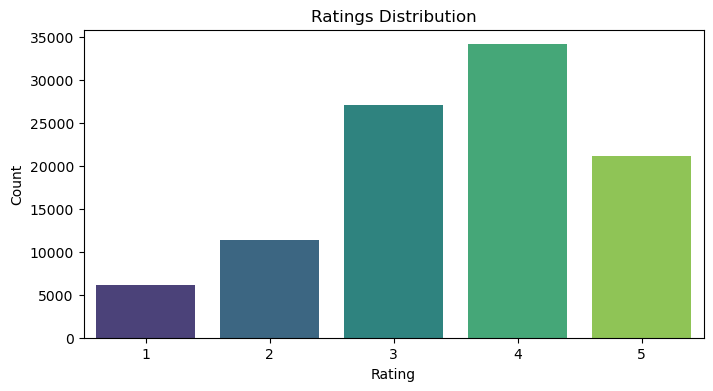

In [55]:
# Ratings distribution
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=dataset, palette='viridis')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [56]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Highest Ratings provided is 4 while least is 1

In [57]:
print(f"Mean global rating: {round(dataset['rating'].mean(),2)}.")

mean_ratings = dataset.groupby('user_id')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.59.


# Exploring the demographic data of the users

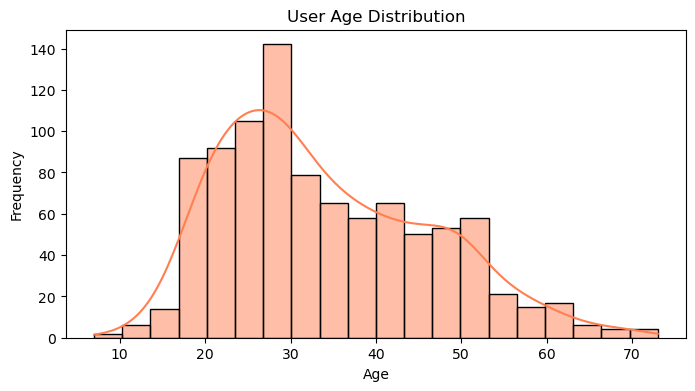

In [58]:
# Age distribution
plt.figure(figsize=(8, 4))
sns.histplot(user['age'], bins=20, kde=True, color='coral')
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Population with age between 25-30 are the highest user of the movie platform

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\3100524429.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=user, palette='coolwarm')


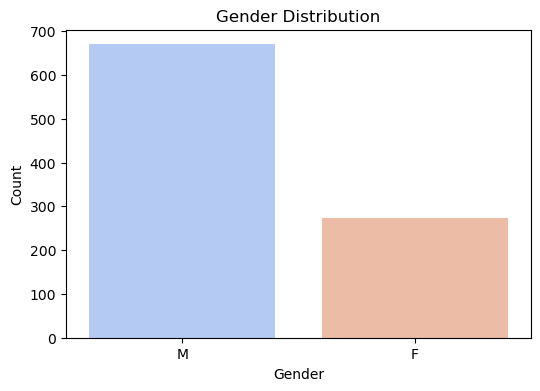

In [59]:
# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=user, palette='coolwarm')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Males are the highest consumers of the movie platform

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\900989297.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='occupation', data=user, order=user['occupation'].value_counts().index, palette='cubehelix')


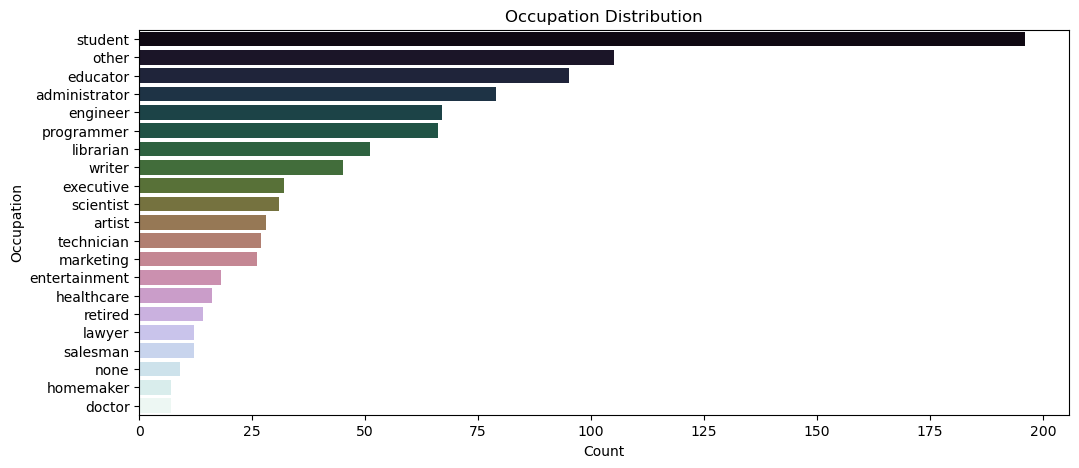

In [60]:
# Occupation distribution
plt.figure(figsize=(12, 5))
sns.countplot(y='occupation', data=user, order=user['occupation'].value_counts().index, palette='cubehelix')
plt.title('Occupation Distribution')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

Students are the highest consumer of the movie platform

In [61]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [62]:
item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [63]:
movie_ratings = dataset.merge(item, left_on='item_id', right_on = "movie_id")
movie_ratings['movie_title'].value_counts()[0:10]

movie_title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\1073693957.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_rated.values, y=most_rated_titles.values, palette='mako')


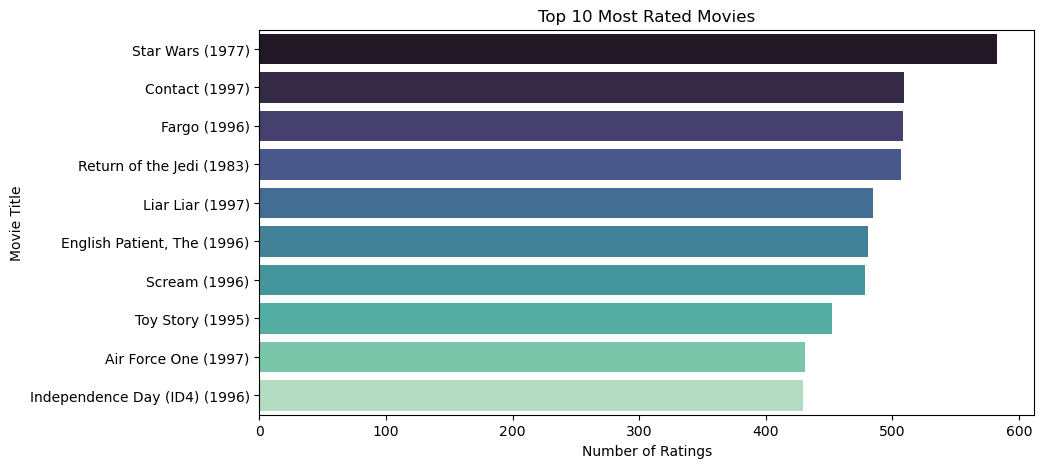

In [64]:
# Most rated movies
most_rated = dataset.groupby('item_id').size().sort_values(ascending=False).head(10)
most_rated_titles = item.set_index('movie_id').loc[most_rated.index]['movie_title']
plt.figure(figsize=(10, 5))
sns.barplot(x=most_rated.values, y=most_rated_titles.values, palette='mako')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


Above are the top 10 rated movies - Highest is Star Wars(1977)

# Lowest and highest rated movies

Lowest rated movie:

In [65]:
mean_ratings = movie_ratings.groupby('movie_id')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
item[item['movie_id']==lowest_rated][['movie_id','movie_title']]

,movie_id,movie_title
313,314,3 Ninjas: High Noon At Mega Mountain (1998)


Highest Rated movie:

In [66]:
highest_rated = mean_ratings['rating'].idxmax()
item[item['movie_id'] == highest_rated][['movie_id','movie_title']]

,movie_id,movie_title
813,814,"Great Day in Harlem, A (1994)"


In [67]:
dataset[dataset['item_id']==highest_rated]

,user_id,item_id,rating,timestamp
6519,13,814,5,1998-02-01 03:04:21


As we can observe in above two cells - 'Great Day in Harlem' has only 1 rating, therefore it is showed as Highest rated movie.
This insight will be wrong if we mention if 'Great Day in Harlem' is highest rated movie. Therefore to know the highest rated movie, we should look at Baysian Average

Bayesian Average
Bayesian Average is defined as:

𝑟𝑖=𝐶×𝑚+Σreviews/𝐶+𝑁
 

where  𝐶
  represents our confidence,  𝑚
  represents our prior, and  𝑁
  is the total number of reviews for movie  𝑖
 . In this case, our prior  𝑚
  will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make  𝐶
  be the average number of ratings for a given movie.


In [68]:
movie_stats = dataset.groupby('item_id')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
item_id,,
1,452,3.878319
2,131,3.206107
3,90,3.033333
4,209,3.550239
5,86,3.302326


In [69]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


In [70]:
bayesian_avg_ratings = dataset.groupby('item_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['item_id', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='item_id')

In [71]:
item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [72]:
movie_stats.head(2)

,item_id,count,mean,bayesian_avg
0,1,452,3.878319,3.785
1,2,131,3.206107,3.166


In [73]:
movie_stats = movie_stats.merge(item[['movie_id', 'movie_title']], left_on = 'item_id', right_on = 'movie_id')
movie_stats.sort_values('bayesian_avg', ascending=False).head(10)

,item_id,count,mean,bayesian_avg,movie_id,movie_title
49,50,583,4.358491,4.240,50,Star Wars (1977)
316,318,298,4.466443,4.235,318,Schindler's List (1993)
63,64,283,4.445230,4.208,64,"Shawshank Redemption, The (1994)"
481,483,243,4.456790,4.185,483,Casablanca (1942)
11,12,267,4.385768,4.147,12,"Usual Suspects, The (1995)"
126,127,413,4.283293,4.131,127,"Godfather, The (1972)"
97,98,390,4.289744,4.129,98,"Silence of the Lambs, The (1991)"
173,174,420,4.252381,4.107,174,Raiders of the Lost Ark (1981)
601,603,209,4.387560,4.097,603,Rear Window (1954)
311,313,350,4.245714,4.076,313,Titanic (1997)


Our top 10 highly rated movies are different than that of mean, Star Wars, Schindler's list, Shawshank Redemption are the highest rated movies

In [74]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,item_id,count,mean,bayesian_avg,movie_id,movie_title
686,688,44,1.840909,2.551,688,Leave It to Beaver (1997)
685,687,69,2.188406,2.599,687,McHale's Navy (1997)
121,122,106,2.339623,2.604,122,"Cable Guy, The (1996)"
888,890,43,1.953488,2.605,890,Mortal Kombat: Annihilation (1997)
986,988,86,2.313953,2.625,988,"Beautician and the Beast, The (1997)"


- Our top 10 highly rated movies through baysian average are different than that of normal average, 
- Star Wars, Schindler's list, Shawshank Redemption are the highest rated movies

C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\3397262569.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_ratings.keys()), y=list(genre_ratings.values()), palette='Set3')


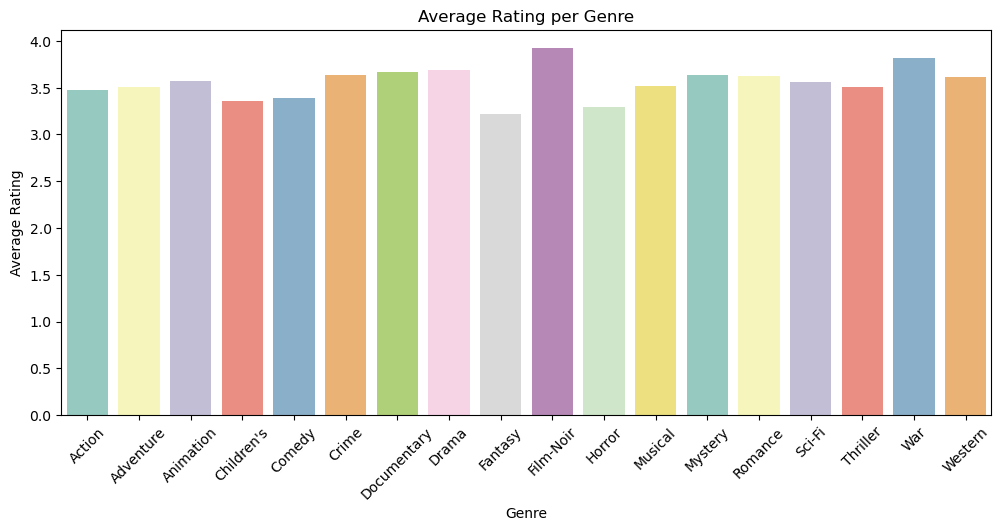

In [75]:
# Average rating per genre
genre_cols = item.columns[6:]  # All genre columns
item_genre = item[['movie_id'] + list(genre_cols)].copy()
dataset_genre = pd.merge(dataset, item_genre, left_on='item_id', right_on='movie_id')

genre_ratings = {}
for genre_name in genre_cols:
    genre_ratings[genre_name] = dataset_genre[dataset_genre[genre_name] == 1]['rating'].mean()

plt.figure(figsize=(12, 5))
sns.barplot(x=list(genre_ratings.keys()), y=list(genre_ratings.values()), palette='Set3')
plt.xticks(rotation=45)
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()

Ratings are highest for Film-Noir Genre & lowest for Fantasy Genre

In [76]:
item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [77]:
genre_columns = item.columns[5:]  # Adjust index if needed

In [78]:
# Sum up each genre to get the count of movies per genre
genre_counts = item[genre_columns].sum().sort_values(ascending=False)

In [79]:
# Display the most frequent genre
most_frequent_genre = genre_counts.idxmax()
most_frequent_count = genre_counts.max()

In [80]:
print("🎬 Most Frequent Genre:", most_frequent_genre)
print("📊 Count:", most_frequent_count)
# Optional: Display top 5 genres
print("\nTop 5 Genres:\n", genre_counts.head())

🎬 Most Frequent Genre: Drama
📊 Count: 724

Top 5 Genres:
 Drama       724
Comedy      505
Thriller    251
Action      250
Romance     247
dtype: int64


Frequently rated genre are Drama, Comedy, Thriller

In [81]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['user_id'].nunique()
    N = df['item_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["item_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["item_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [movie_mapper[i] for i in df['item_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(dataset)

In [82]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [83]:
dataset.shape

(100000, 4)

In [84]:
X.shape

(943, 1682)

In [85]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.3%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [86]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

943

In [87]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 737 movies.
Least active user rated 20 movies.


In [88]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

1682

In [89]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 583 ratings.
Least rated movie has 1 ratings.


C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\3364525973.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_6540\3364525973.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


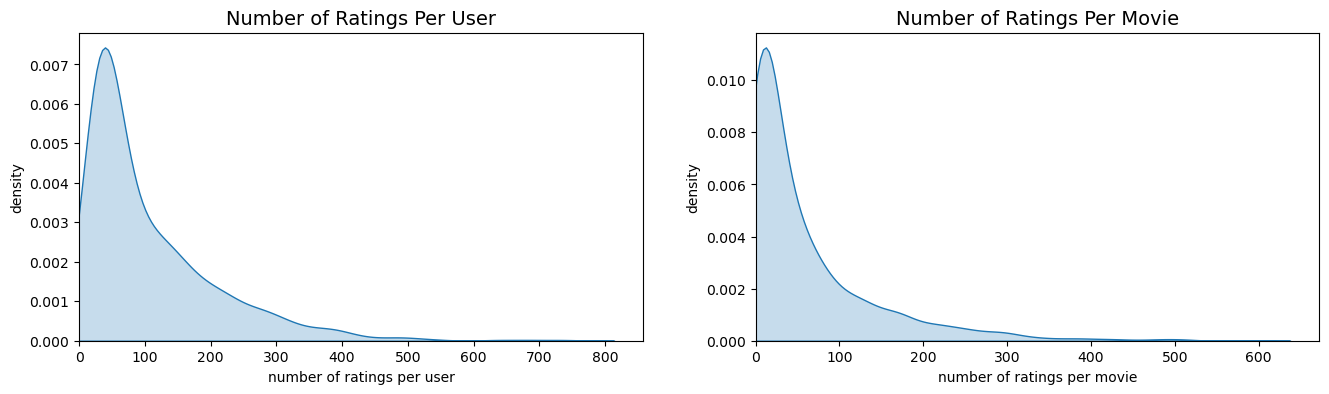

In [90]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

# Item-item Recommendations with k-Nearest Neighbors

In [91]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [92]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[50, 181, 121, 117, 405, 151, 222, 100, 237]

In [93]:
item.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),1995-01-01 00:00:00,1995-01-01 00:00:00,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


find_similar_movies() returns a list of movieId's that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps movieId to title

In [94]:
movie_titles = dict(zip(item['movie_id'], item['movie_title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Star Wars (1977)
Return of the Jedi (1983)
Independence Day (ID4) (1996)
Rock, The (1996)
Mission: Impossible (1996)
Willy Wonka and the Chocolate Factory (1971)
Star Trek: First Contact (1996)
Fargo (1996)
Jerry Maguire (1996)


The results above show the 10 movies that are most similar to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach.

# Movie Recommendation using SVD (Singular Value Decomposition (SVD)

In [106]:
# Now, import the required libraries:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

In [107]:
reader = Reader(rating_scale=(1, 5))  # Ratings range from 1 to 5
data_surprise = Dataset.load_from_df(dataset[["user_id", "item_id", "rating"]], reader)

In [108]:
# Use SVD for recommendations
model = SVD()

# Perform cross-validation to check performance
cross_validate(model, data_surprise, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9328  0.9384  0.9319  0.9327  0.9367  0.9345  0.0026  
MAE (testset)     0.7330  0.7401  0.7352  0.7372  0.7381  0.7367  0.0024  
Fit time          0.78    0.72    0.74    0.76    0.75    0.75    0.02    
Test time         0.08    0.07    0.07    0.17    0.09    0.09    0.04    


{'test_rmse': array([0.93282824, 0.93838897, 0.9318686 , 0.93274877, 0.93666521]),
 'test_mae': array([0.73303882, 0.74006026, 0.73517041, 0.73721199, 0.73812769]),
 'fit_time': (0.7808902263641357,
  0.7156500816345215,
  0.7369918823242188,
  0.7628393173217773,
  0.7486276626586914),
 'test_time': (0.07828998565673828,
  0.06662511825561523,
  0.0700678825378418,
  0.1696021556854248,
  0.08664536476135254)}

In [109]:
trainset = data_surprise.build_full_trainset()
model.fit(trainset)

In [110]:
random_user_id = dataset["user_id"].sample(1).iloc[0]  # Pick a random user
print(f"Generating recommendations for User ID: {random_user_id}")

Generating recommendations for User ID: 87


In [111]:
# Get all movie IDs
all_movie_ids = set(dataset["item_id"].unique())

# Get movies this user has rated
watched_movie_ids = set(dataset[dataset["user_id"] == random_user_id]["item_id"].unique())

# Get unwatched movies
unwatched_movie_ids = list(all_movie_ids - watched_movie_ids)

In [112]:
predictions = [model.predict(random_user_id, movie_id) for movie_id in unwatched_movie_ids]

# Sort predictions by estimated rating (descending order)
predictions.sort(key=lambda x: x.est, reverse=True)

In [113]:
top_10_movies = predictions[:10]  # Get the top 10 predictions

# Fetch movie titles
recommended_movie_titles = [item[item["movie_id"] == pred.iid]["movie_title"].values[0] for pred in top_10_movies]

print("🎬 Top 10 Movie Recommendations:")
for idx, title in enumerate(recommended_movie_titles, 1):
    print(f"{idx}. {title}")

🎬 Top 10 Movie Recommendations:
1. Forrest Gump (1994)
2. Hunt for Red October, The (1990)
3. Third Man, The (1949)
4. Casablanca (1942)
5. Apollo 13 (1995)
6. Silence of the Lambs, The (1991)
7. Great Escape, The (1963)
8. As Good As It Gets (1997)
9. African Queen, The (1951)
10. North by Northwest (1959)


# Movie Recommendation using Collaborative filtering

In [114]:
# 2. Merge dataset + user + item
merged_data = dataset.merge(user, on='user_id')
merged_full = merged_data.merge(item, left_on='item_id', right_on='movie_id')

In [115]:
merged_full.head()

,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,movie_id,movie_title,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,49,M,writer,55105,242,Kolya (1996),...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,1998-04-04 19:22:22,39,F,executive,00000,302,L.A. Confidential (1997),...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,1997-11-07 07:18:36,25,M,writer,40206,377,Heavyweights (1994),...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,1997-11-27 05:02:03,28,M,technician,80525,51,Legends of the Fall (1994),...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,1998-02-02 05:33:16,47,M,educator,55113,346,Jackie Brown (1997),...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Create a User-Movie Rating Matrix
user_movie_matrix = merged_full.pivot(index='user_id', columns='movie_id', values='rating')
user_movie_matrix.fillna(0, inplace=True)  # Replace NaN values with 0 (no rating)


In [117]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between movies
movie_similarity_matrix = cosine_similarity(user_movie_matrix.T)  # Transpose to compare movies
movie_similarity_df = pd.DataFrame(movie_similarity_matrix, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)


In [118]:
import numpy as np

# Function to predict ratings
def predict_rating(user_id, movie_id):
    # Get the similarity scores for the movie
    similar_movies = movie_similarity_df[movie_id]
    
    # Get the ratings for all movies from the user
    user_ratings = user_movie_matrix.loc[user_id]
    
    # Calculate weighted sum of ratings for movies the user has already rated
    weighted_sum = np.dot(similar_movies, user_ratings)
    
    # Calculate sum of similarities for the weighted ratings
    sum_of_similarities = similar_movies[user_ratings > 0].sum()
    
    # Predict rating (if sum_of_similarities is 0, return 0)
    if sum_of_similarities == 0:
        return 0
    else:
        return weighted_sum / sum_of_similarities


In [119]:
# Function to recommend movies to a user
def recommend_movies(user_id, top_n=5):
    # List of movies user has already rated
    rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    
    # List of all movies
    all_movies = user_movie_matrix.columns
    
    # Movies the user hasn't rated yet
    unrated_movies = list(set(all_movies) - set(rated_movies))
    
    # Predict ratings for unrated movies
    movie_predictions = {}
    for movie in unrated_movies:
        movie_predictions[movie] = predict_rating(user_id, movie)
    
    # Sort the predicted ratings and return top N recommendations
    recommended_movies = sorted(movie_predictions.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Get movie titles based on the movie IDs (from the item DataFrame)
    recommended_movie_titles = item.set_index('movie_id').loc[[x[0] for x in recommended_movies], 'movie_title']
    
    return recommended_movie_titles

# Example: Recommend top 5 movies for user with ID 1
recommended_movies = recommend_movies(user_id=312, top_n=10)
print(recommended_movies)


movie_id
1293                                      Star Kid (1997)
1235                          Big Bang Theory, The (1994)
1236                     Other Voices, Other Rooms (1997)
1433                                  Men of Means (1998)
1613                                    Tokyo Fist (1995)
1617                                     Hugo Pool (1997)
1624                                          Hush (1998)
1625                                    Nightwatch (1997)
1653    Entertaining Angels: The Dorothy Day Story (1996)
1671                            Further Gesture, A (1996)
Name: movie_title, dtype: object


# Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

user-factor matrix (n_users, k)
item-factor matrix (k, n_items)
We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature 
 represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

In [120]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(1682, 20)

In [121]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Willy Wonka and the Chocolate Factory (1971)
Star Trek: First Contact (1996)
Independence Day (ID4) (1996)
Star Wars (1977)
Return of the Jedi (1983)
Mission: Impossible (1996)
Rock, The (1996)
Mr. Holland's Opus (1995)
Hunchback of Notre Dame, The (1996)
